In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import numpy as np
import lmfit

In [2]:
    config = {'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor': '.4',
    'axes.labelcolor': '.0',
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'figure.autolayout': True,
    'figure.figsize': (4.5, 3.5),
    'font.family': ['serif'],
    'font.size': 10.0,
    'grid.linestyle': '--',
    'legend.facecolor': '.9',
    'legend.frameon': True,
    'savefig.transparent': True,
    'text.color': '.0',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',}

    plt.style.use(['seaborn-whitegrid', 'seaborn-paper', 'seaborn-muted', config])

In [3]:
#caminhos para fazer os DataFrames
df_fermi = pd.read_csv ("CSVs\Dados_Fermi.csv")
df_energia = pd.read_csv("CSVs\Dados_energia.csv")

## Métricas:

### Modelo Baseline:

In [4]:
# Calcular o erro quadrático médio - medindo o modelo baseline
from sklearn.metrics import mean_squared_error
def RMSE(x_teste, y_teste, modelo):
    y_verdadeiro = y_teste
    y_previsao = modelo.predict(x_teste)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    

    return print(f"O RMSE do modelo baseline foi de {RMSE}, porcentagem em relação a média: {abs((RMSE/y_teste.mean()) * 100)}.")

#### Para a energia de fermi:

In [5]:
# Define o tamanho dos dados de teste e de treino e cria os dataframes

from sklearn.model_selection import train_test_split


#escolhe o tamanho do nosso teste
TAMANHO_TESTE = 0.1
# fixa quais dados que vão ser selecionados para teste e treino
SEMENTE_ALEATORIA = 24569
DATASET_NAME = "df_fermi"
# faz uma lista de features que queremos usar, no caso são todas
FEATURES = list(df_fermi.keys())
# tira o nosso target entre as features
FEATURES.remove("Fermi_energy")
FEATURES.remove("Unnamed: 0")
#o que queremos achar
TARGET = ["Fermi_energy"]


indices = df_fermi.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_fe = df_fermi.loc[indices_treino]
df_teste_fe = df_fermi.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
x_treino_fe = df_treino_fe.reindex(FEATURES, axis=1).values
y_treino_fe = df_treino_fe.reindex(TARGET, axis=1).values
x_teste_fe = df_teste_fe.reindex(FEATURES, axis=1).values
y_teste_fe = df_teste_fe.reindex(TARGET, axis=1).values


### Baseline média:

In [6]:
# Criar um modelo regressor "dummy"
from sklearn.dummy import DummyRegressor

# cria o modelo
modelo_baseline_fe = DummyRegressor()

# treina o modelo
modelo_baseline_fe.fit(x_treino_fe, y_treino_fe)

# realiza uma previsão usando o modelo treinado
previsao_fe = modelo_baseline_fe.predict(x_teste_fe)

print(previsao_fe)

[-4.95704166 -4.95704166 -4.95704166 ... -4.95704166 -4.95704166
 -4.95704166]


In [7]:
# testando a qualidade do nosso modelo:
RMSE(x_teste_fe, y_teste_fe, modelo_baseline_fe )

O RMSE do modelo baseline foi de 0.30151342169015477, porcentagem em relação a média: 6.078721445684178.


### Para energia por átomo:

In [8]:
# Criar os dados de teste e de treino

#escolhe o tamanho do nosso teste
tamanho_teste = 0.1
# fixa quais dados que vão ser selecionados para teste e treino
semente_aleatoria = 24569
# faz uma lista de features que queremos usar, no caso são todas
features = list(df_energia.keys())
# tira o nosso target entre as features
features.remove("energy_per_atom")
features.remove("Unnamed: 0")
#o que queremos achar
target = ["energy_per_atom"]


indices = df_energia.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state= semente_aleatoria
)

df_treino_en = df_energia.loc[indices_treino]
df_teste_en = df_energia.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
x_treino_en = df_treino_en.reindex(features, axis=1).values
y_treino_en = df_treino_en.reindex(target, axis=1).values
x_teste_en = df_teste_en.reindex(features, axis=1).values
y_teste_en = df_teste_en.reindex(target, axis=1).values

### Baseline média

In [9]:
# Cria e testa o modelo de regressor "Dummy" para a energia por átomo
# cria o modelo
modelo_baseline_en = DummyRegressor()

# treina o modelo
modelo_baseline_en.fit(x_treino_en, y_treino_en)

# realiza uma previsão usando o modelo treinado
previsao_en = modelo_baseline_en.predict(x_teste_en)

print(previsao_en)

[-47.41313446 -47.41313446 -47.41313446 ... -47.41313446 -47.41313446
 -47.41313446]


In [10]:
# testando a qualidade do nosso modelo:
RMSE(x_teste_en, y_teste_en, modelo_baseline_en )

O RMSE do modelo baseline foi de 2.353630547946566, porcentagem em relação a média: 4.965411373597822.


# Modelo KNN

In [11]:
#Cria o algoritmo de identificação de vizinhos mais próximos;

def identificacaoknn(x_treino, y_treino, x_teste, y_teste, target_name): #Definir uma função para calcular os vizinhos, já que temos dois targets numéricos
    "Essa função utiliza os dados para calcular a previsão através de um intervalo de número de k-vizinhos e calcula o RMSE e erro percentual do modelo"
    media_teste = y_teste.mean()
    media_treino = y_treino.mean()

    from sklearn.metrics import mean_squared_error 
    from sklearn.neighbors import KNeighborsRegressor
    
    #variando o hiperparâmetro k, que corresponde ao numero de vizinhos
    numero_vizinhos = range(1, 101)
    rmse = []
    for n in numero_vizinhos: #for para testar
        # função para criar o modelo com a qtde n de vizinhos
        modelo_knn = KNeighborsRegressor(n_neighbors=n)

        # treina o modelo
        modelo_knn.fit(x_treino, y_treino)

        # realiza uma previsão usando o modelo treinado
        previsao = modelo_knn.predict(x_teste)
        #print(previsao)

        y_verdadeiro = y_teste
        y_previsao = modelo_knn.predict(x_teste)
        RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
        rmse.append(RMSE)
        
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(numero_vizinhos, rmse, c = 'r')
    ax1.set_xlabel('Número de vizinhos')
    ax1.set_ylabel('RMSE (eV)')
    
    m = min(rmse)
    km = numero_vizinhos[rmse.index(m)]
    
            # função para criar o modelo com a qtde n de vizinhos
    modelo_knn = KNeighborsRegressor(n_neighbors=km)

        # treina o modelo
    modelo_knn.fit(x_treino, y_treino)

        # realiza uma previsão usando o modelo treinado
    previsao = modelo_knn.predict(x_teste)
        #print(previsao)

    y_verdadeiro = y_teste
    y_previsao = modelo_knn.predict(x_teste)
        
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange', label = f'RMSE:{RMSE:.4f}')
    ax2.plot(y_verdadeiro,y_verdadeiro,label="y = x", c = 'r') ; ax2.legend(fontsize='small')
    
    if target_name ==  'Energia de Fermi':
        ax2.set_title('k-NN', fontsize = 22)
    if target_name == 'Energia por Átomo':
        ax2.set_title('k-NN', fontsize = 22)

    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    plt.savefig(f'imagens\knn_{target_name}', dpi = 200)
    
    print(f"O RMSE do modelo k-NN usando k={km} foi de {m} eV. O erro percentual é, {abs((m/media_teste) * 100)} %")

O RMSE do modelo k-NN usando k=25 foi de 0.08594171465090313 eV. O erro percentual é, 1.7326450709851542 %


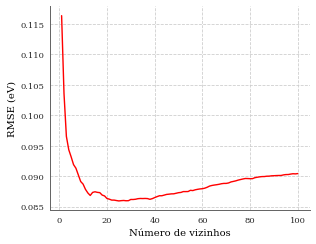

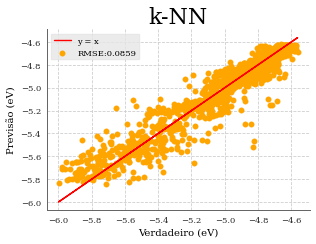

In [12]:
identificacaoknn(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe, 'Energia de Fermi')

O RMSE do modelo k-NN usando k=3 foi de 0.8057468565124171 eV. O erro percentual é, 1.6998694247310895 %


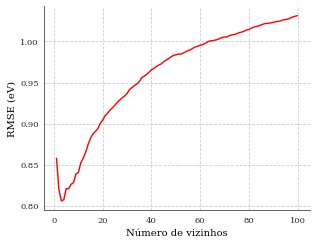

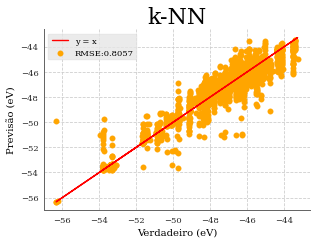

In [13]:
identificacaoknn(x_treino_en, y_treino_en, x_teste_en, y_teste_en, 'Energia por Átomo')

#### Para a energia de Fermi, o modelo de k-NN resultou em um RMSE cerca de 3.5 vezes menor que o baseline, já para a energia total por átomo resultou em um RMSE cerca de 3 vezes menor que o baseline. Ou seja, comparando os dois modelos, o k-NN é melhor.

# Modelo Linear (não normalizado):

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
# Cria o modelo de regressão linear e realiza a predição, além de calcular o RMSE

def modelo_linear(x_treino, y_treino, x_teste, y_teste, target_name):
    # cria o modelo
    modelo_linear = LinearRegression()

    # treina o modelo
    modelo_linear.fit(x_treino, y_treino)

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_linear.predict(x_teste)
    #print(previsao)

    y_verdadeiro = y_teste
    y_previsao = modelo_linear.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange',label = f'RMSE:{RMSE:.4f}')
    ax2.plot(y_verdadeiro,y_verdadeiro,label="y=x", c = 'r') ; ax2.legend(fontsize='small')
    if target_name ==  'Energia de Fermi':
        ax2.set_title('Regressão Linear', fontsize = 22)
    if target_name == 'Energia por Átomo':
        ax2.set_title('Regressão Linear', fontsize = 22)
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    
    plt.savefig(f'imagens\Linear_{target_name}', dpi = 200)
    
    print(f"O modelo linear produziu um RMSE de {RMSE} eV")

### Energia de Fermi:

O modelo linear produziu um RMSE de 0.09438584636064312 eV


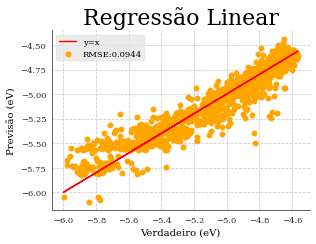

In [16]:
#Testando o modelo para a energia de Fermi:
modelo_linear(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe, 'Energia de Fermi')

Para a energia de Fermi o modelo linear deu um resultado melhor que o baseline, mas pior que o kNN

### Energia por átomo

O modelo linear produziu um RMSE de 0.4226204459755578 eV


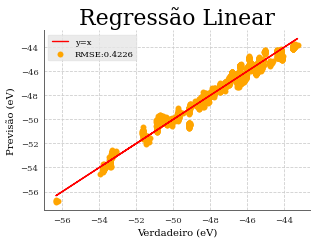

In [17]:
#Testando o modelo para energia por átomo
modelo_linear(x_treino_en, y_treino_en, x_teste_en, y_teste_en, 'Energia por Átomo')

Esse modelo se mostrou melhor para a energia por átomo do que o modelo baseline e kNN.

# Modelo Linear (normalizado):

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Cria o modelo linear normalizado e testa a predição
def modelo_linear_normalizado(x_treino, y_treino, x_teste, y_teste, target_name):

    normalizador_x = MinMaxScaler()
    normalizador_y = MinMaxScaler()

    normalizador_x.fit(x_treino)
    normalizador_y.fit(y_treino)
    # cria o modelo
    modelo_linear = LinearRegression()

    # treina o modelo
    modelo_linear.fit(
        normalizador_x.transform(x_treino),
        normalizador_y.transform(y_treino),
    )

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_linear.predict(normalizador_x.transform(x_treino))
    previsao = normalizador_y.inverse_transform(previsao)
    #print(previsao)
    y_verdadeiro = y_teste
    y_previsao = modelo_linear.predict(normalizador_x.transform(x_teste))
    y_previsao = normalizador_y.inverse_transform(y_previsao)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange')
    ax2.plot(y_verdadeiro,y_verdadeiro,label="y=x", c = 'r') ; ax2.legend(fontsize='small')
    if target_name ==  'Energia de Fermi':
        ax2.set_title('Previsão linear (normalizado) para Energia de Fermi')
    if target_name == 'Energia por Átomo':
        ax2.set_title('Previsão linear (normalizado) para Energia por Átomo')
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')

    print(f"O RMSE do modelo linear normalizado foi de {RMSE} eV.")

### Energia de Fermi

O RMSE do modelo linear normalizado foi de 0.09438584636064316 eV.


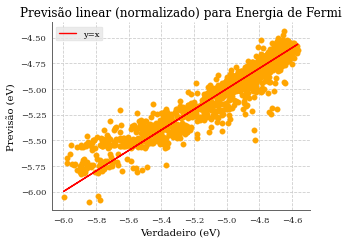

In [20]:
#Teste do modelo e RMSE
modelo_linear_normalizado(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe,'Energia de Fermi' )

### Energia por Átomo

O RMSE do modelo linear normalizado foi de 0.42262044597555626 eV.


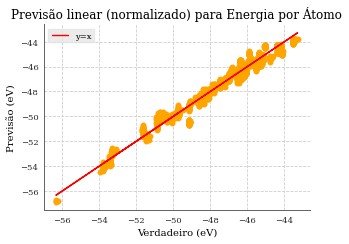

In [21]:
#Teste do modelo e RMSE
modelo_linear_normalizado(x_treino_en, y_treino_en, x_teste_en, y_teste_en,'Energia por Átomo')

Quando analisamo o RMSE, nota-se que a normalização não alterou a qualidade do modelo.

# Árvore de decisão:

### Testando Hiperparâmetros - teste das features e quantidade exemplos utilizados

In [22]:
from sklearn.tree import DecisionTreeRegressor

from itertools import product
def hiper_arvore(X_treino, y_treino, X_teste, y_teste):
    "Define o modelo de árvore de decisão e testando qual hiperparâmetro será melhor"
    # variar o número de exemplos que serão utilizados
    NUM_FOLHAS =list( range(10,100,10))
    NUM_FOLHAS.append(None)
    
    NUM_PROFUNDIDADE = list(range(10,100,10))
    NUM_PROFUNDIDADE.append(None)
    #cria uma biblioteca para RMSE
    RMSEl = {}

    #cria e testa o modelo para a variação de n° de folhas e profundidade: 
    for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
        modelo_dt = DecisionTreeRegressor(
            max_leaf_nodes=n_folhas,
            max_depth=n_profundidade,
            random_state=SEMENTE_ALEATORIA,
        )

        modelo_dt.fit(X_treino, y_treino)

        y_verdadeiro = y_teste
        y_previsao = modelo_dt.predict(X_teste)
        RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
        RMSEl.update({RMSE: [n_folhas, n_profundidade]})

    #vendo menor RMSE para identificar qual foi o melhor hiperparâmetro: 
    m = min(RMSEl.keys())
    print(
        f"O menor RMSE usando o modelo AD foi de {m:.3f} ev, usando max_leaf_nodes={RMSEl[m][0]} "
        f"e max_depth={RMSEl[m][1]}."
    )
    
    
    return RMSEl[m][0], RMSEl[m][1]

In [23]:
n_folhas_fe, n_profundidade_fe =  hiper_arvore(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe)

O menor RMSE usando o modelo AD foi de 0.086 ev, usando max_leaf_nodes=50 e max_depth=None.


In [24]:
n_folhas_en, n_profundidade_en =  hiper_arvore(x_treino_en, y_treino_en, x_teste_en, y_teste_en)

O menor RMSE usando o modelo AD foi de 0.035 ev, usando max_leaf_nodes=None e max_depth=None.


## Definindo a árvore que usa os melhores hiperparâmetros identificados acima:

In [25]:
from sklearn import tree

def arvore(x_treino, y_treino, x_teste, y_teste, target_name,n_folhas, n_profundidade):
    "Define e testa o modelo de árvore de decisão"
    
    modelo_dt = DecisionTreeRegressor(random_state=SEMENTE_ALEATORIA, max_leaf_nodes=n_folhas,max_depth=n_profundidade,)

    # treina o modelo
    modelo_dt.fit(x_treino, y_treino)

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_dt.predict(x_teste)
    y_verdadeiro = y_teste
    
    y_previsao = modelo_dt.predict(x_teste)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange',label = f'RMSE:{RMSE:.4f}')
    ax2.plot(y_verdadeiro,y_verdadeiro,label="y=x", c = 'r') ; ax2.legend(fontsize='small')

    if target_name ==  'Energia de Fermi':
        ax2.set_title('Árvore de Decisão', fontsize = 22)
        F = FEATURES
        path = r'imagens\arvore_fe.png'
    if target_name == 'Energia por Átomo':
        ax2.set_title('Árvore de Decisão', fontsize = 22)
        F = features
        path = r'imagens\arvore_en.png'
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    
    plt.savefig(path, dpi = 200)
    
    # cria os objetos de figura e eixo
    fig, axe = plt.subplots(
        ncols=1,
        nrows=1,
        figsize=(7, 4),
        dpi=150,
    )

    # plota o grafo da árvore de decisão
    tree.plot_tree(
        modelo_dt,
        feature_names=F,
        ax=axe,
        impurity=False,
        filled=True,
        proportion=True,
        precision=2,
    
    )
    #print(y_verdadeiro,y_previsao) não deu certo
    #confusion_matrix(list(y_verdadeiro), list(y_previsao))
    
    
    # mostra o plot para o usuário
    plt.show()


    print(f"O RMSE do modelo árvore de decisão foi de {RMSE} eV.")

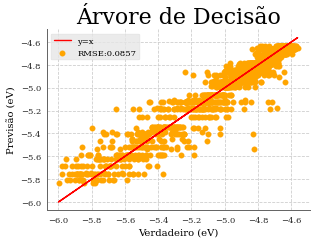

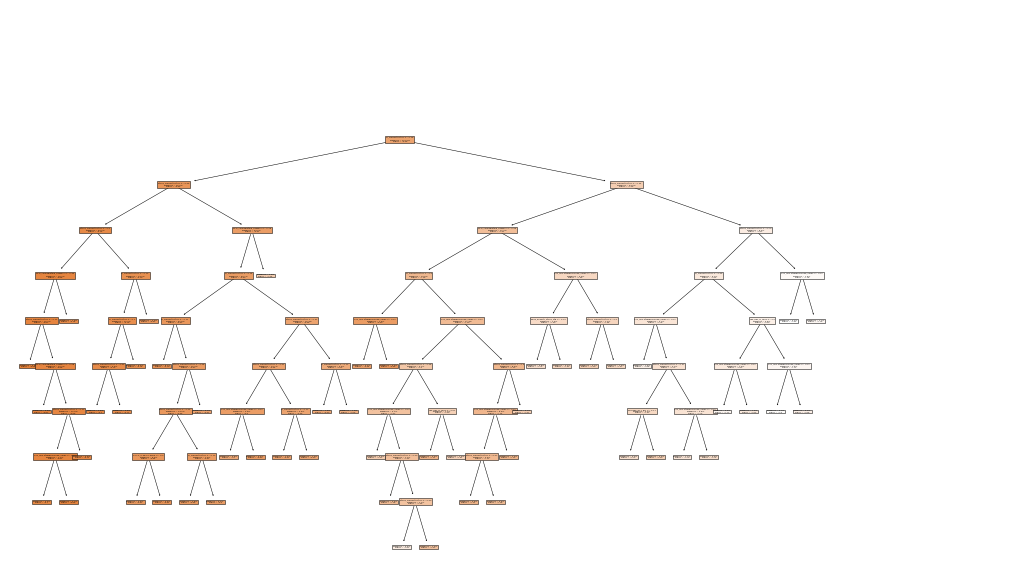

O RMSE do modelo árvore de decisão foi de 0.08565519410995863 eV.


In [26]:
# Teste da árvore para energia de fermi
arvore(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe,'Energia de Fermi' ,n_folhas_fe, n_profundidade_fe)

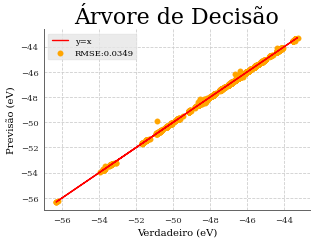

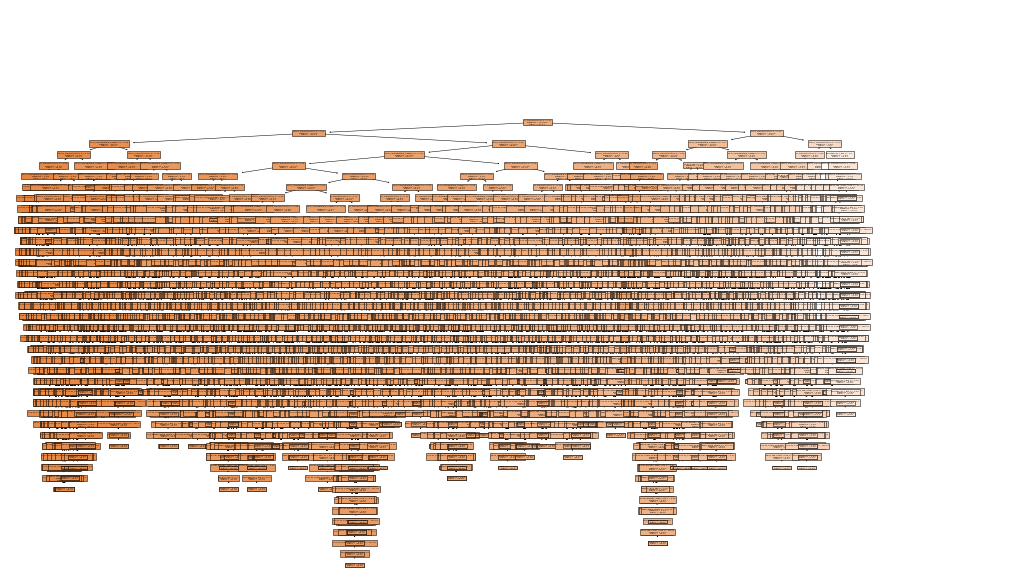

O RMSE do modelo árvore de decisão foi de 0.034933276927750445 eV.


In [27]:
# Teste da árvore para enregia por átomo
arvore(x_treino_en, y_treino_en, x_teste_en, y_teste_en,'Energia por Átomo' ,n_folhas_en, n_profundidade_en)

## Floresta Aleatória

### definindo os melhores hiperparâmetros para a floresta aleatória

In [28]:
from itertools import product
from sklearn.ensemble import RandomForestRegressor


def hiper_floresta(x_treino, y_treino, x_teste, y_teste, target_name):
    "Função que define modelo de floresta aleatória e testa qual hiperparâmetro será melhor"
    NUM_ARVORES = [100,200,300]
    NUM_FOLHAS = [None,100,20]
    NUM_PROFUNDIDADE = [None,5,10]
    RMSEl = {}

    #Variar o número dos hiperparâmetros
    for n_folhas, n_profundidade, n_arvores in product(
        NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
    ):
        modelo_rf = RandomForestRegressor(
            n_estimators=n_arvores,
            max_leaf_nodes=n_folhas,
            max_depth=n_profundidade,
            random_state=SEMENTE_ALEATORIA,
            n_jobs=4,
        )

        modelo_rf.fit(x_treino, y_treino.ravel()) 

        y_verdadeiro = (y_teste)
        y_previsao = modelo_rf.predict(x_teste)
        
        #testa RMSE para cada caso, que identificará o melhor hiperparâmetro
        RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False) 
        RMSEl.update ({RMSE: [n_folhas, n_profundidade, n_arvores]})
    
    m = min(RMSEl.keys())

    print(
        f"O menor RMSE achado do modelo RF usando para target_name "
        f"n_estimators={RMSEl[m][2]} max_leaf_nodes={RMSEl[m][0]} "
        f"e max_depth={RMSEl[m][1]} foi de {m} eV."
    )
    return RMSEl[m][0], RMSEl[m][1], RMSEl[m][2]

In [29]:
n_folhas_fe, n_profundidade_fe, n_arvores_fe = hiper_floresta(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe, "Energia de Fermi")

O menor RMSE achado do modelo RF usando para target_name n_estimators=300 max_leaf_nodes=None e max_depth=None foi de 0.08088742588577415 eV.


In [30]:
n_folhas_en, n_profundidade_en, n_arvores_en = hiper_floresta(x_treino_en, y_treino_en, x_teste_en, y_teste_en, "Energia por atomo")

O menor RMSE achado do modelo RF usando para target_name n_estimators=100 max_leaf_nodes=None e max_depth=None foi de 0.026130406662969126 eV.


## Fazendo a floresta aleatória com os parâmetros escolhidos pela função acima:

In [31]:
from sklearn.metrics import confusion_matrix

def floresta(x_treino, y_treino, x_teste, y_teste, target_name, n_folhas, n_profundidade, n_arvores):
    "Teste e treino do modelo"
    # alterando o formato do target
    #print(y_treino.shape, y_teste.shape)
    y_treino = y_treino.ravel()
    y_teste = y_teste.ravel()
    #print(y_treino.shape, y_teste.shape)

    # cria o modelo
    modelo_rf = RandomForestRegressor(random_state=SEMENTE_ALEATORIA,n_estimators=n_arvores, max_leaf_nodes=n_folhas,max_depth=n_profundidade)

    # treina o modelo
    modelo_rf.fit(x_treino, y_treino)

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_rf.predict(x_teste)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(x_teste)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    #Criar gráficos
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange',label = f'RMSE:{RMSE:.4f}')
    ax2.plot(y_verdadeiro,y_verdadeiro,label="y=x", c = 'r') ; ax2.legend(fontsize='small')

    if target_name ==  'Energia de Fermi':
        ax2.set_title('Floresta Aleatória', fontsize = 22)
        F = FEATURES
        path = r'imagens\floresta_fe.png'
    if target_name == 'Energia por Átomo':
        ax2.set_title('Floresta Aleatória', fontsize = 22)
        F = features
        path = r'imagens\floresta_en.png'
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    plt.savefig(path, dpi = 200)
    
    importancia = modelo_rf.feature_importances_
    desvio_padrao = np.std(
        [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
    )

    serie_importancia = pd.Series(importancia, index=F)

    fig, axe = plt.subplots()
    serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe, color = 'g')
    axe.set_ylabel("Redução média da impureza")
    plt.show()

    print(f"O RMSE do modelo floresta aleatória para {target_name} foi de {RMSE} eV.")

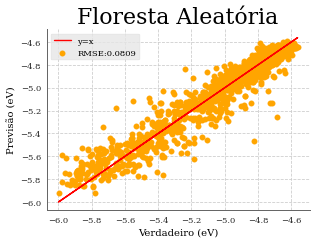

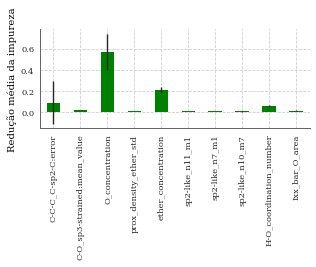

O RMSE do modelo floresta aleatória para Energia de Fermi foi de 0.08088742588577415 eV.


In [32]:
#Teste do modelo para energia de fermi;
floresta(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe,'Energia de Fermi' ,n_folhas_fe, n_profundidade_fe, n_arvores_fe )

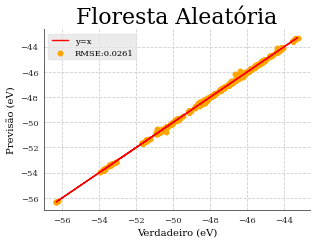

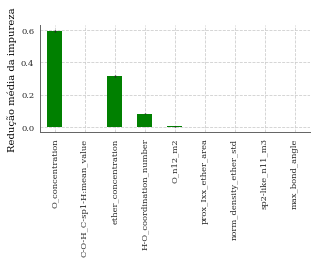

O RMSE do modelo floresta aleatória para Energia por Átomo foi de 0.02613040666296919 eV.


In [33]:
#Teste do modelo para energia por átomo:
floresta(x_treino_en, y_treino_en, x_teste_en, y_teste_en,'Energia por Átomo',n_folhas_en, n_profundidade_en, n_arvores_en)

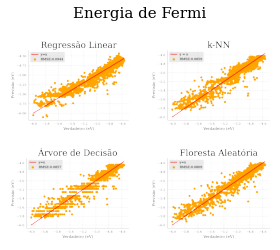

In [34]:
# graficos comparativos
import matplotlib.image as mpimg

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

st = fig.suptitle("Energia de Fermi", fontsize=15)

A = mpimg.imread(r'imagens\Linear_Energia de Fermi.png')
ax1.imshow(A)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

B = mpimg.imread(r'imagens\knn_Energia de Fermi.png')
ax2.imshow(B)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

C = mpimg.imread(r'imagens\arvore_fe.png')
ax3.imshow(C)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])

D = mpimg.imread(r'imagens\floresta_fe.png')
ax4.imshow(D)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

plt.savefig(r'imagens\multiplot_Energia de Fermi.png', dpi = 200)

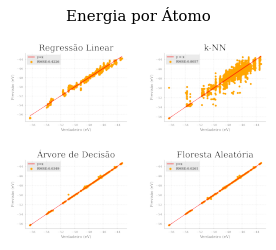

In [35]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

st = fig.suptitle("Energia por Átomo", fontsize=15)

A = mpimg.imread(r'imagens\Linear_Energia por Átomo.png')
ax1.imshow(A)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

B = mpimg.imread(r'imagens\knn_Energia por Átomo.png')
ax2.imshow(B)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

C = mpimg.imread(r'imagens\arvore_en.png')
ax3.imshow(C)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])

D = mpimg.imread(r'imagens\floresta_en.png')
ax4.imshow(D)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

plt.savefig(r'imagens\multiplot_Energia por Átomo.png', dpi = 200)